# DBSCAN experimentos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## Implementación

In [2]:
def dist(a, b):  # Distancia euclidiana
    return np.sqrt(np.sum((a - b) ** 2))

def range_query(DB,dist,p1,radius):
    neighbors = []
    for p2 in range(len(DB)):
        if dist(p1,DB[p2]) <= radius:
            neighbors.append(p2)
    return neighbors

def dbscan_with_kdtree(DB, radius, minPts, kdtree):
    label = [None] * len(DB)
    cluster = -1
    for p in range(len(DB)):
        if label[p] is not None:
            continue
        
        # Encuentra los vecinos dentro del radio utilizando el KD-Tree
        neighbors_indices = kdtree.query_ball_point(DB[p], radius)
        
        if len(neighbors_indices) < minPts:
            label[p] = -1
            continue
        
        cluster += 1
        label[p] = cluster
        S = set(neighbors_indices)
        while S:
            q = S.pop()
            if label[q] == -1:
                label[q] = cluster
            if label[q] is not None:
                continue
            
            # Encuentra los vecinos dentro del radio utilizando el KD-Tree
            neighbors_indices = kdtree.query_ball_point(DB[q], radius)
            label[q] = cluster
            if len(neighbors_indices) >= minPts:
                S.update(neighbors_indices)
    return label

## Import Data

In [3]:
df_tissue = pd.read_csv('./dataset/dataset_tissue.txt',sep=',',index_col=0)
df_clases = pd.read_csv('./dataset/clase.txt',sep=',',index_col=0)
# Obtener los nombres de las clases del DataFrame
tissue_names = df_clases['x'].tolist()

## PCA

In [4]:
df_tissue_transposed = df_tissue.T
n_components = 70
pca = PCA(n_components=n_components)
dt_tissue_pca = pca.fit_transform(df_tissue_transposed)

## Silhouette

In [5]:
def graficar_silueta(idx_eps,idx_samples,X,label):
    import matplotlib.pyplot as plt
    from sklearn.metrics import silhouette_samples

    # Calcula las puntuaciones de Silhouette para cada muestra
    silhouette_values = silhouette_samples(X, label)

    # Calcula la puntuación de Silhouette promedio para todos los datos
    silhouette_avg = silhouette_score(X, label)

    # Crea un gráfico de barras para mostrar las puntuaciones de Silhouette individuales
    fig, ax = plt.subplots(figsize=(10, 6))

    y_lower = 10
    for i in np.unique(label):
        cluster_silhouette_values = silhouette_values[label == i]
        cluster_silhouette_values.sort()
        
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.viridis(i / len(np.unique(label)))
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Etiqueta para cada cluster
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Calcula el siguiente y_lower para el próximo cluster en el gráfico
        y_lower = y_upper + 10

    # Línea vertical para la puntuación de Silhouette promedio de todos los datos
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Etiqueta para la puntuación de Silhouette promedio
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    ax.set_xlabel("Puntuación de Silhouette")
    plt.title(f"Puntuación de Silhouette para cada cluster (Promedio: {silhouette_avg:.2f})")
    # Añadir texto a la esquina derecha
    plt.text(0.95, 0.95, f'eps: {idx_eps}\nmin_samples: {idx_samples}',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes,  # Para especificar coordenadas relativas al sistema de ejes
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  # Opcional: un cuadro para resaltar el texto

    plt.show()

## Busqueda Exhaustiva
Esto es para encontrar los mejores parametros para el algoritmo DBSCAN, cuando lo ejecutamos generó más de 300 imágenes, por lo que no es recomendable ejecutarlo de nuevo, pero si se desea se puede ejecutar la siguiente celda.

In [6]:
# idx_eps, idx_samples = 0, 0
# for i in range(3,6):
#     j = 5.02
#     while j < 100:
#         label = dbscan_with_kdtree(dt_tissue_pca, j, i, KDTree(dt_tissue_pca))
#         # Filtra los puntos de ruido (label == -1)
#         # Verifica si se generan al menos dos clusters
#         if(label.count(-1) > 6 or len(np.unique(label)) < 8 or len(np.unique(label)) > 9):
#             j+=0.02
#             continue
#         idx_eps = j
#         idx_samples = i
#         graficar_silueta(idx_eps,idx_samples,dt_tissue_pca,label)
#         j+=0.02

## Hallar Indices
Esta función nos sirve para poder obtener los indices de los elementos que pertenecen a cada cluster, esto nos servirá para poder obtener los elementos que pertenecen a cada cluster y poder graficarlos.

In [7]:
#Mejor combinacion de parametros
label = dbscan_with_kdtree(dt_tissue_pca, 77.0600000000182, 3, KDTree(dt_tissue_pca))
def hallar_indices(label):
    dict_idx = {}
    for i in range(len(label)):
        if(label[i] not in dict_idx):
            dict_idx[label[i]] = [i]
        else:
            dict_idx[label[i]].append(i)
    return dict_idx
#Codigo para hallar los nombres de los tejidos de cada cluster
lista = []
dict_idx = hallar_indices(label)
indice = 0 #Por ejemplo, si queremos saber los nombres de los tejidos del cluster 0
for i in dict_idx[indice]:
    lista.append(tissue_names[i])
lista
#Esto nos sirvió para saber los nombres que más se repiten en cada cluster, con eso sacamos el siguiente diccionario
# diccionario = {
#     "kidney":0,
#     "hippocampus":1,
#     "cerebellum":2,
#     "colon":3,
#     "liver":4,
#     "endometrium":5,
#     "cerebellum":6,
#     "placenta":7
# }
#Nota: Cerebellum se repite dos veces, 2 clusters tienen cerebellum como mayor tejido que se repite en ellos.


['kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney',
 'kidney']

## Normalizamos clusters
Como 2 clusters tienen a cerebellum como nombre que más se repite es necesario normalizar los nombres de los clusters para que no se repitan. Por ello optamos por cambiar los clusters "6" por "2".

In [8]:

new_label = []
for i in label:
    if(i == 6):
        new_label.append(2)
    else:
        new_label.append(i)
diccionario = {
    "Ruido":-1,
    "kidney":0,
    "hippocampus":1,
    "cerebellum":2,
    "colon":3,
    "liver":4,
    "endometrium":5,
    "placenta":7
}
# 'labels_true' son las etiquetas reales sacadas de "clase.txt". Nos van a servir para comparar con las etiquetas que nos da el algoritmo

labels_true = []
for i in range(len(new_label)):
    labels_true.append(diccionario[tissue_names[i]])

print("-----------------LABELS TRUE----------------")
print(labels_true)
print("-----------------NEW LABEL----------------")
print(new_label)

-----------------LABELS TRUE----------------
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 4, 4, 4, 0, 0, 0, 4, 4, 4, 0, 0, 2, 1, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7]
-----------------NEW LABEL----------------
[0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

## Métricas Utilizadas

### Silhouette
La métrica de Silhouette es una medida de cuán similar es un objeto a su propio clúster (cohesión) en comparación con otros clústeres (separación). La puntuación Silhouette es un promedio de la puntuación de Silhouette de cada punto.

silhouette_score:  0.37354726208058225


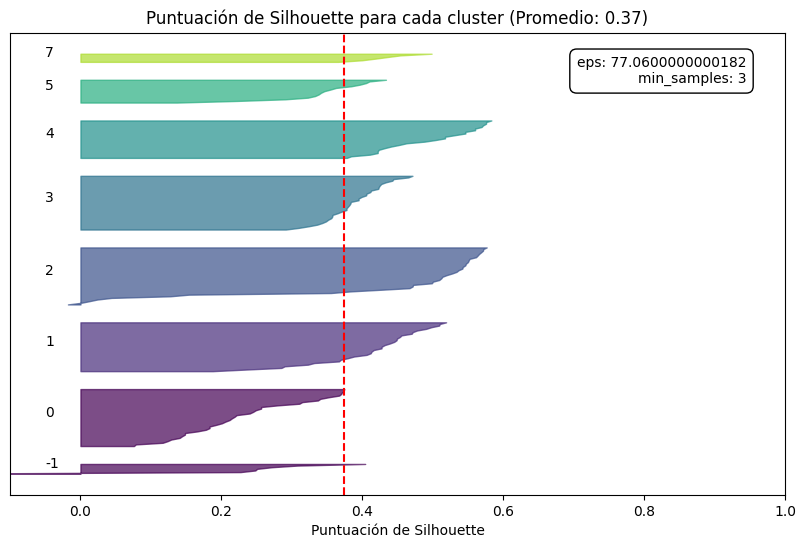

In [9]:
score = silhouette_score(dt_tissue_pca, new_label)
print("silhouette_score: ", score)
graficar_silueta(77.0600000000182,3,dt_tissue_pca,new_label)

### Rand Index Adjusted

In [10]:
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(labels_true, new_label)

print("Indice rand: ",rand_index)

Indice rand:  0.9484252506142171


### Mutual information

In [11]:
from sklearn.metrics.cluster import normalized_mutual_info_score as mi

mutual_information = mi(labels_true, new_label)
print("Mutual information: ",mutual_information)


Mutual information:  0.9536436650459541


### Matriz de similitud

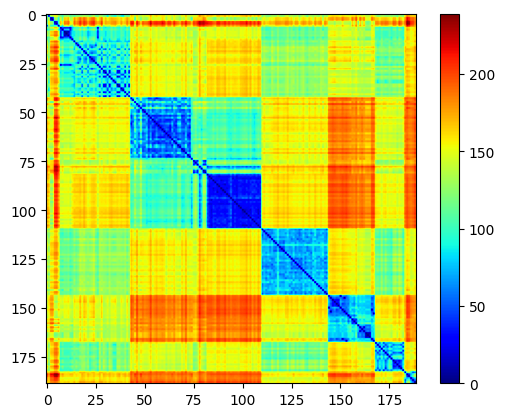

In [12]:
from sklearn.metrics import pairwise_distances
# Ordenar los datos según su etiqueta de cluster
sorted_data = dt_tissue_pca[np.argsort(new_label)]
# Calcular la matriz de similitud
similarity_matrix = pairwise_distances(sorted_data, metric='euclidean')

# Mostrar la matriz de similitud
plt.imshow(similarity_matrix, cmap='jet')
plt.colorbar()
plt.show()

### Dendograma

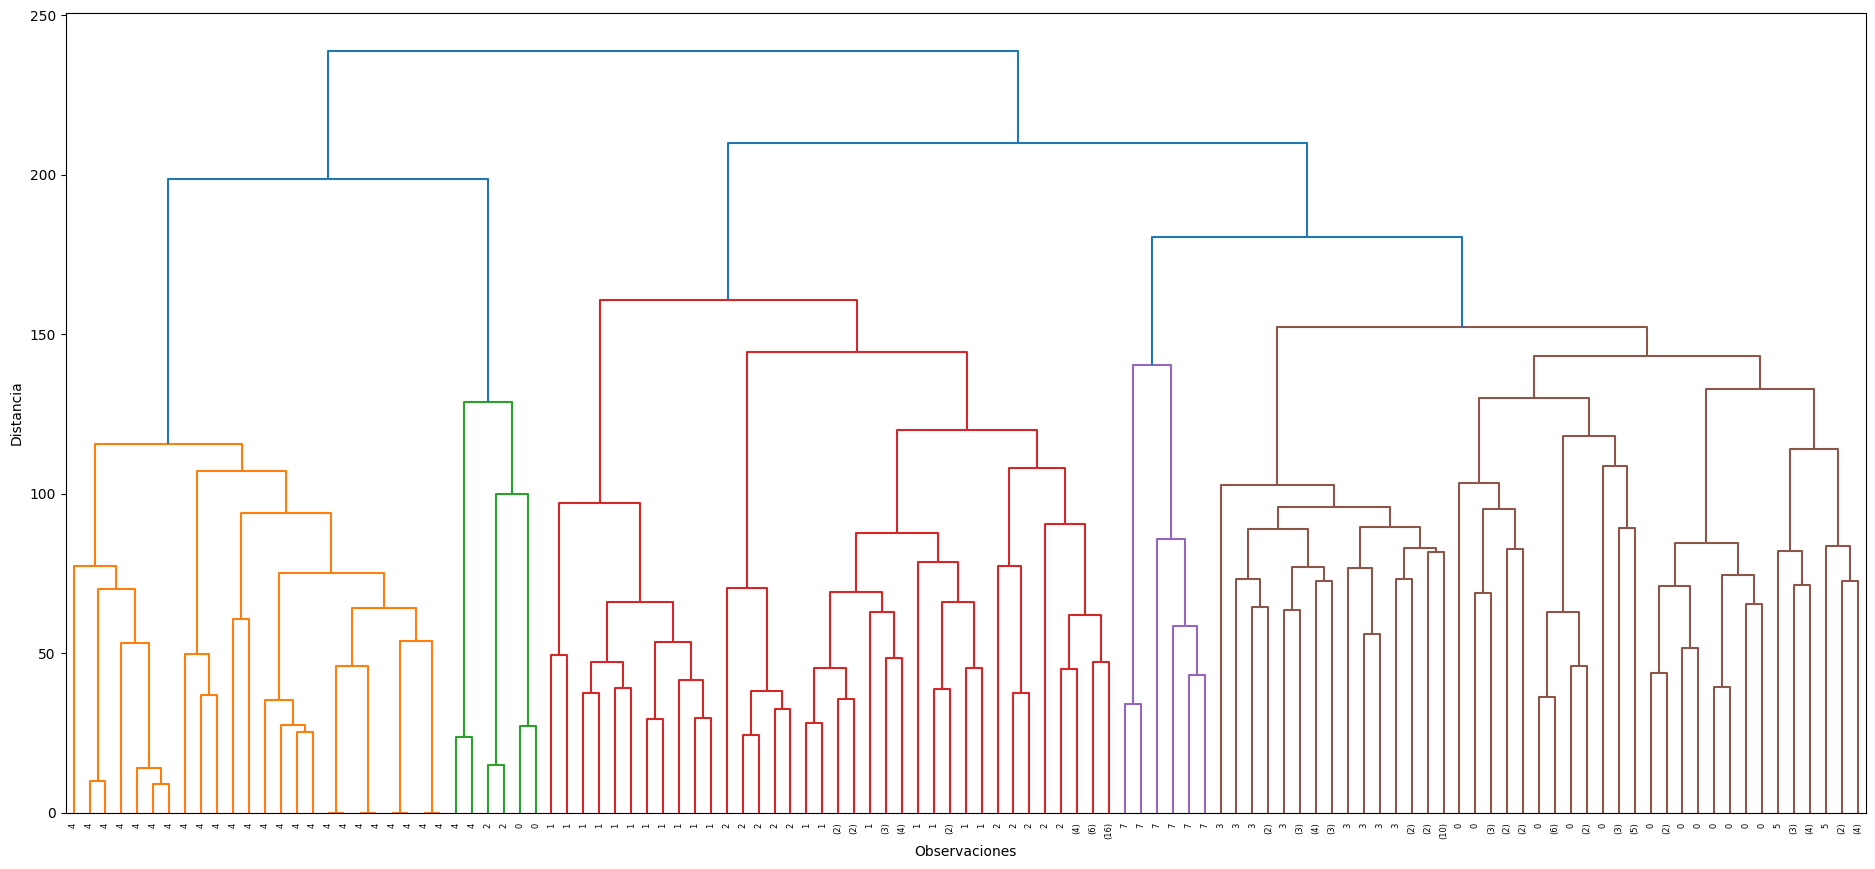

In [13]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# Calcular la matriz de distancias a partir de los datos
distances = pdist(dt_tissue_pca)

# Realizar el clustering jerárquico
linkage_matrix = linkage(distances, method='complete')

# Crear la figura con tamaño personalizado
fig = plt.figure(figsize=(20, 10))

# Crear el dendrograma
dendrogram(linkage_matrix,
           labels=labels_true,
           truncate_mode='level',
           p=8,
           leaf_rotation=90,
           leaf_font_size=6)
plt.xlabel('Observaciones')

plt.ylabel('Distancia')
# Ajustar el tamaño de la figura para dejar suficiente espacio para el dendrograma
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9)
# Mostrar el dendrograma
plt.show()